In [1]:
# Google Cloud Configurations
PROJECT = 'data-engineering-gcp'


# Sampling PNAD 2015

In [2]:
# Collect from Big Query all the data for adults, i.e. people older than 18

query_all_table="""
SELECT *
    
FROM 
    `data-engineering-gcp.PNAD_2015.join_individuals_households` 

WHERE 
    V8005_age>=18
    
ORDER BY
    household_index,V0301_inhabitant_order_in_household
    

"""

In [3]:
import pandas as pd
data_all=pd.read_gbq(query_all_table, project_id=PROJECT, index_col=None, col_order=None, reauth=False, verbose=True, 
                   private_key=None, dialect='standard')
                 

Requesting query... ok.
Job ID: 420c8208-9834-464b-a03c-f80e62872d64
Query running...
Query done.
Cache hit.

Retrieving results...
Got 261634 rows.

Total time taken 377.06 s.
Finished at 2018-05-01 11:30:02.


In [4]:
import pandas as pd

df_all = data_all


# Cleanup procedure
Eliminate None, and '' from the dataframe

In [5]:
print(df_all.shape)

(261634, 73)


In [6]:
df_all['monthly_family_income'].mean()

3289.5944296230614

In [7]:
df_all['Class'].unique()

array(['E', 'D', 'C', 'B', 'A', 'not declared'], dtype=object)

# Visualization of familes per social class
Using total family income

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

# function to draw a bar chart showing the distribution of a variable in percentage of total
def plot_bar_chart(variable,y_label=None,title=None,color='SkyBlue',width = 0.30, x_axis_width=5,rotation=0):
    
    counter = Counter(variable.tolist())
    counter = sorted(counter.items())

    values = [i[1] for i in counter]
    values_percentage= [round((x / sum(values))*100,1) for x in list(map(float, values))]
    x_labels = [i[0] for i in counter]
    ind = np.arange(len(values))  # the x locations for the groups
    
    fig = plt.figure(figsize=(x_axis_width, 5))
    ax = fig.add_subplot(111)
  

    #fig, ax = plt.subplots()
    rects = ax.bar(ind - width/2, values_percentage, width, 
                color=color)


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(ind-width/2)
    ax.set_xticklabels(x_labels)
    plt.xticks(rotation=rotation)
    plt.yticks(np.arange(0, max(values_percentage)+5,2),visible=False)
    


    xpos = 'center'
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off
    #percentages = [x/sum(values) for x in values]

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')
    plt.show()
    
    return

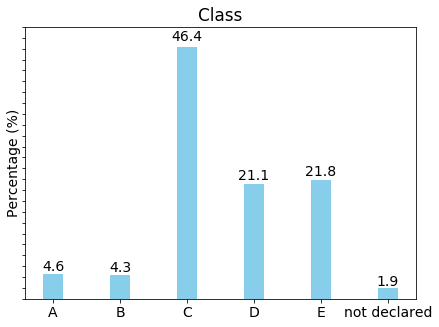

In [19]:
# Plotting a bar chart social class distribution, counting households only once
# The "drop_duplicates" of household_index is used for that.
plot_bar_chart(df_all.drop_duplicates('household_index')['Class'],
               y_label='Percentage (%)',title='Class',color='SkyBlue',width = 0.30,x_axis_width=7)

In [20]:
import matplotlib.pyplot as plt
import numpy as np
#function for a boxplot chart to show the income distribution per social class
def print_boxplot(df,x_axis_width=7, y_axis_height=7):
    
    fig = plt.figure(figsize=(x_axis_width, y_axis_height))
    ax = fig.add_subplot(111)
    data = [df.loc[df.Class == 'E','monthly_family_income'],
            df.loc[df.Class == 'D','monthly_family_income'],
            df.loc[df.Class == 'C','monthly_family_income'],
            df.loc[df.Class == 'B','monthly_family_income'],
            df.loc[df.Class == 'A','monthly_family_income']]
    labels = ['E','D','C','B','A']
    plt.yticks(np.arange(0, data[4].max(), 2500))
    ax.boxplot(data,labels=labels,showfliers=False)
    plt.show()
    return

/home/lopasso/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


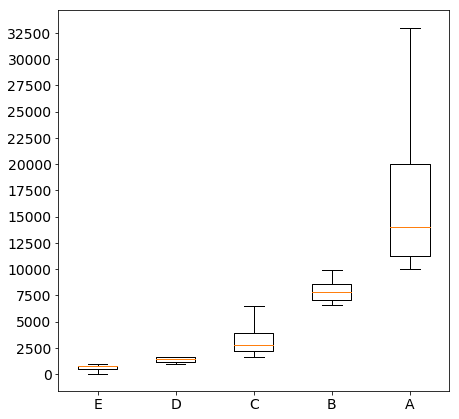

In [21]:
print_boxplot(df_all.drop_duplicates('household_index'))

## Feature Engineering

In [22]:
def clean_data(df):
  df.loc[:,'people_per_bathroom']=df.loc[:,'V4724_number_of_people_in_family']/df.loc[:,'V2016_number_of_bathrooms']
  df.loc[:,'people_per_room']=df.loc[:,'V4724_number_of_people_in_family']/df.loc[:,'V0205_number_of_rooms']
  df.loc[:,'people_per_bedroom']=df.loc[:,'V4724_number_of_people_in_family']/df.loc[:,'V0206_number_of_bedrooms']
  
  COLUMNS_TO_FLOAT = ['V4724_number_of_people_in_family','V8005_age','V2016_number_of_bathrooms','V0205_number_of_rooms',
        'V0206_number_of_bedrooms','people_per_bathroom','people_per_room','people_per_bedroom']
  df[COLUMNS_TO_FLOAT] = df[COLUMNS_TO_FLOAT].astype(np.float32)

  booleanDictionary = {True: 'True', False: 'False'}
  df.V0601_read_write =  df.V0601_read_write.replace(booleanDictionary)

  type_of_areaDictionary = {'Urban – city or town, urbanized area' : 'urban',
                            'Rural – rural zone, not conglomerate' : 'rural',
                            'Rural – rural conglomerate, isolated, town' : 'rural',
                            'urban – city or town, not urbanized area' : 'urban',
                            'Rural – conglomerate of urban extension' : 'rural',
                            'Rural – rural conglomerate, isolated, nucleos' : 'rural',
                            'Urban – isolated urban area' : 'urban',
                            'Rural – rural conglomerate, isolated, other conglomerates' : 'rural'}

  df.V4728_type_of_area =  df.V4728_type_of_area.replace(type_of_areaDictionary)
  
  df['income_range']=''
  df.loc[df['monthly_family_income'] <=6585, 'income_range']  = 'income<=6585'
  df.loc[df['monthly_family_income'] >6585,'income_range'] = 'income>6585'
  df.loc[df['Class'] =='not declared','income_range'] = 'not declared'
  
  
  df_features = ['household_index', 'UF_string', 'V0302_gender', 'V4745_highest_level_of_education', 'V8005_age',
                'V0404_race', 'V4011_marital_status', 'V0601_read_write',
                'V4715_position_at_work_last_year', 'V4816_economic_activity_last_year',
                'V4817_occupational_work_groups_last_year', 'V4723_family_type',
                'V4724_number_of_people_in_family', 'V4728_type_of_area', 
                'V0201_household_specie_a', 'V0202_household_type_a',
                'V0203_wall_material_a', 'V0204_roof_material_a',
                'V0205_number_of_rooms', 'V0206_number_of_bedrooms',
                'V0207_occupation_condition_a', 'V0210_terrain_is_owned_a',
                'V0211_water_service_a', 'V0212_water_source_a', 'V0215_bathroom',
                'V0216_shared_bathroom_a', 'V2016_number_of_bathrooms',
                'V0217_sewage_type_a', 'V0218_trash_disposal_a', 'V0219_lightening_a',
                'V0220_mobile_phone', 'V2020_fixed_phone',
                'V0221_stove_2_or_more_burners', 'V0222_stove_1_burner',
                'V0223_type_of_stove_fuel_a', 'V0224_water_filter', 'V0225_radio',
                'V0226_color_TV_set', 'V0228_fridge_type_a', 'V0229_freezer',
                'V0230_washing_machine', 'V0231_personal_computer',
                'V0232_PC_acessing_Internet', 'V2032_car_motorcycle_a','people_per_bathroom', 'people_per_room',
                'people_per_bedroom','income_range']

  df=df[df_features]
  df = df.dropna(how="any", axis=0)
  
  return df


In [23]:
df = clean_data(df_all)


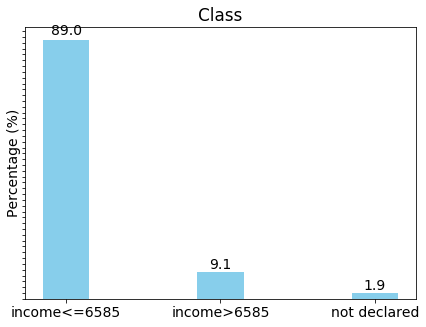

In [24]:
plot_bar_chart(df.drop_duplicates('household_index')['income_range'],
               y_label='Percentage (%)',title='Class',color='SkyBlue',width = 0.30,x_axis_width=7)

In [25]:
df.shape


(255077, 48)

# Data split into train, validation and test datasets

In [65]:
dataset_not_declared = df.loc[df['income_range']=='not declared']
dataset = df.loc[df['income_range']!='not declared'] # dataset has no more 'not declared'

print(dataset_not_declared.shape,dataset.shape)

(5383, 48) (249694, 48)


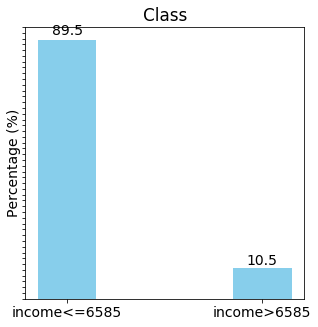

In [66]:
plot_bar_chart(dataset['income_range'],
               y_label='Percentage (%)',title='Class',color='SkyBlue',width = 0.30,x_axis_width=5)

In [67]:
# In order to avoid data leakage we are controlling individuals that will be included in each dataset(train, validation and test) 
# to be from 
# the same family, i.e., for each family, all the members will go either to train or test dataset. This will avoid that we will
# test and individuals whose family data was used to train the model using the data from another member of the same family

family_index_unique = dataset.drop_duplicates('household_index')['household_index']

test_index = family_index_unique.sample(frac=0.1, random_state=15)

X_features = ['UF_string',  'V4745_highest_level_of_education', 'V8005_age',
       'V0404_race', 'V4011_marital_status', 'V0601_read_write',
       'V4715_position_at_work_last_year', 'V4816_economic_activity_last_year',
       'V4817_occupational_work_groups_last_year', 'V4723_family_type',
       'V4724_number_of_people_in_family', 'V4728_type_of_area', 
       'V0201_household_specie_a', 'V0202_household_type_a',
       'V0205_number_of_rooms', 'V0206_number_of_bedrooms',
       'V0207_occupation_condition_a', 'V0210_terrain_is_owned_a',
       'V0215_bathroom', 'V0216_shared_bathroom_a', 'V2016_number_of_bathrooms',
       'V2020_fixed_phone','V0230_washing_machine', 'V0231_personal_computer',
       'V0232_PC_acessing_Internet', 'V2032_car_motorcycle_a','people_per_bathroom', 'people_per_room',
       'people_per_bedroom']
y_labels = ['income_range']

X_test = dataset.loc[dataset['household_index'].isin(test_index), X_features]
y_test = dataset.loc[dataset['household_index'].isin(test_index), y_labels]

dataset_without_test = dataset.loc[~dataset['household_index'].isin(test_index)]

In [68]:
print(X_test.shape,y_test.shape,dataset_without_test.shape)

(24903, 29) (24903, 1) (224791, 48)


In [69]:
family_index_unique2 = dataset_without_test.drop_duplicates('household_index')['household_index']

validation_index = family_index_unique2.sample(frac=0.1, random_state=15)

dataset_validation = dataset_without_test.loc[dataset_without_test['household_index'].isin(validation_index)]
dataset_train = dataset_without_test.loc[~dataset_without_test['household_index'].isin(validation_index)]

In [70]:
print(dataset_validation.shape,dataset_train.shape)

(22527, 48) (202264, 48)


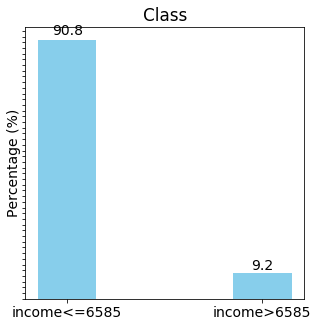

In [71]:
plot_bar_chart(dataset_train.drop_duplicates('household_index')['income_range'],
               y_label='Percentage (%)',title='Class',color='SkyBlue',width = 0.30,x_axis_width=5)

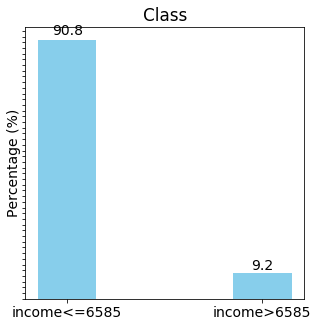

In [72]:
plot_bar_chart(dataset_validation.drop_duplicates('household_index')['income_range'],
               y_label='Percentage (%)',title='Class',color='SkyBlue',width = 0.30,x_axis_width=5)

In [73]:
#undersampling for the validation dataset
undersample = dataset_validation.loc[dataset_validation['income_range']=='income<=6585'].sample(frac=0.12, 
                                                                                                random_state=15)
dataset_validation = dataset_validation.loc[dataset_validation['income_range']=='income>6585'] 
dataset_validation = dataset_validation.append(undersample,ignore_index=True)

In [74]:
dataset_validation.shape


(4820, 48)

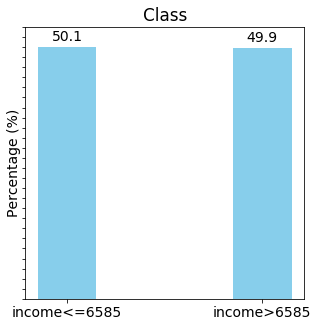

In [75]:
plot_bar_chart(dataset_validation['income_range'],
               y_label='Percentage (%)',title='Class',color='SkyBlue',width = 0.30,x_axis_width=5)

In [76]:
#undersampling for the train dataset
undersample2 = dataset_train.loc[dataset_train['income_range']=='income<=6585'].sample(frac=0.12
                                                                                       , random_state=15)
dataset_train = dataset_train.loc[dataset_train['income_range']=='income>6585'] 
dataset_train = dataset_train.append(undersample2,ignore_index=True)
# shuffle the train dataset
dataset_train = dataset_train.sample(frac=1, axis=1, random_state=15).reset_index(drop=True)

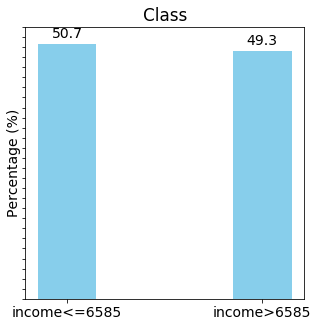

In [77]:
plot_bar_chart(dataset_train['income_range'],
               y_label='Percentage (%)',title='Class',color='SkyBlue',width = 0.30,x_axis_width=5)

In [78]:


X_validation = dataset_validation[X_features]
y_validation = dataset_validation[y_labels]

X_train = dataset_train[X_features]
y_train = dataset_train[y_labels]


In [79]:
print(X_train.shape,y_train.shape,X_validation.shape, y_validation.shape)

(42855, 29) (42855, 1) (4820, 29) (4820, 1)


# Tensorflow Deep-and-wide classification model

In [41]:
import tensorflow as tf

/home/lopasso/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [42]:
dataset.columns

Index(['household_index', 'UF_string', 'V0302_gender',
       'V4745_highest_level_of_education', 'V8005_age', 'V0404_race',
       'V4011_marital_status', 'V0601_read_write',
       'V4715_position_at_work_last_year', 'V4816_economic_activity_last_year',
       'V4817_occupational_work_groups_last_year', 'V4723_family_type',
       'V4724_number_of_people_in_family', 'V4728_type_of_area',
       'V0201_household_specie_a', 'V0202_household_type_a',
       'V0203_wall_material_a', 'V0204_roof_material_a',
       'V0205_number_of_rooms', 'V0206_number_of_bedrooms',
       'V0207_occupation_condition_a', 'V0210_terrain_is_owned_a',
       'V0211_water_service_a', 'V0212_water_source_a', 'V0215_bathroom',
       'V0216_shared_bathroom_a', 'V2016_number_of_bathrooms',
       'V0217_sewage_type_a', 'V0218_trash_disposal_a', 'V0219_lightening_a',
       'V0220_mobile_phone', 'V2020_fixed_phone',
       'V0221_stove_2_or_more_burners', 'V0222_stove_1_burner',
       'V0223_type_of_stove_fuel_

In [43]:
dataset.V0207_occupation_condition_a.unique()

array(['rented', 'owned already paid', 'owned still paying',
       'ceded other way', 'ceded by employer', 'other condition'],
      dtype=object)

In [44]:
# categorical input features


# Individual info

#gender = tf.feature_column.categorical_column_with_vocabulary_list(
#        'V0302_gender',
#        ['female', 'male'])

marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
        'V4011_marital_status',
        ['single', 'legally_divorced', 'not applicable', 'married',
       'separated', 'widowed'])

# Family info

type_of_family = tf.feature_column.categorical_column_with_vocabulary_list(
        'V4723_family_type',
        ['other types of families', 'mother with all kids younger than 14',
       'couple with kids younger and older than 14',
       'couple with kids with 14 or older', 'couple without kids',
       'mother with kids with 14 or older',
       'couple with all kids younger than 14',
       'mother with kids younger and older than 14'])


# Education of the individual

highest_level_of_education = tf.feature_column.categorical_column_with_vocabulary_list(
        'V4745_highest_level_of_education',
        ['completed high school', 'incompleted elementary',
       'incompleted university degree', 'no education',
       'completed elementary', 'completed university degree',
       'indetermined', 'incompleted high school'])

read_write = tf.feature_column.categorical_column_with_vocabulary_list(
        'V0601_read_write',
        [ 'True', 'False'])

# Work of the individual

position_at_work = tf.feature_column.categorical_column_with_vocabulary_list(
        'V4715_position_at_work_last_year',
        ['Public employee', 'not applicable', 'regular employee',
       'Informal employee', 'domestic informal employee', 'self-employed',
       'working on construction for own use', 'employeer',
       'domestic formal employee', 'militar',
       'working on own consumpltion', 'not paid'])

occupational_work_groups = tf.feature_column.categorical_column_with_vocabulary_list(
        'V4817_occupational_work_groups_last_year',
        ['administrative services workers', 'technicians', 'not applicable',
       'sciences and arts professionals',
       'goods and services production workers', 'service workers',
       'agriculture workers', 'salespeople and commerce workers',
       'managers', 'military', 'badly defined occupations'])

economic_activity = tf.feature_column.categorical_column_with_vocabulary_list(
        'V4816_economic_activity_last_year',
        ['public administration', 'education, health and social services',
       'not applicable', 'transformation industry',
       'transport, storage and communication', 'commerce and repair',
       'lodging and catering', 'domestic services',
       'other collective services, social and personal', 'agriculture',
       'construction', 'other manufacturing activities',
       'other activities', 'badly defined activities'])

#Location of the household and type

state = tf.feature_column.categorical_column_with_vocabulary_list(
        'UF_string',
       ['Rondônia', 'Acre', 'Amazonas', 'Roraima', 'Pará', 'Amapá',
       'Tocantins', 'Maranhão', 'Piauí', 'Ceará', 'Rio Grande do Norte',
       'Paraíba', 'Pernambuco', 'Alagoas', 'Sergipe', 'Bahia',
       'Minas Gerais', 'Espírito Santo', 'Rio de Janeiro', 'São Paulo',
       'Paraná', 'Santa Catarina', 'Rio Grande do Sul',
       'Mato Grosso do Sul', 'Mato Grosso', 'Goiás', 'Distrito Federal'])

type_of_census_area = tf.feature_column.categorical_column_with_vocabulary_list(
        'V4728_type_of_area',
        ['urban','rural'])


household_type = tf.feature_column.categorical_column_with_vocabulary_list(
        'V0202_household_type_a',
        ['House', 'Apartment', 'Room'])

household_occupation_condition = tf.feature_column.categorical_column_with_vocabulary_list(
        'V0207_occupation_condition_a',
        ['rented', 'owned already paid', 'owned still paying',
       'ceded by employer', 'ceded other way', 'other condition'])

#census_area = tf.feature_column.categorical_column_with_hash_bucket('UPA_census_area',hash_bucket_size=100, dtype=tf.string)

# household goods

car_motorcycle = tf.feature_column.categorical_column_with_vocabulary_list(
        'V2032_car_motorcycle_a',
        ['Car', 'Motorcycle', 'Car and motorcycle', 'No'])

PC_acessing_Internet = tf.feature_column.categorical_column_with_vocabulary_list(
        'V0232_PC_acessing_Internet',
        ['true', 'not applicable', 'false'])

personal_computer = tf.feature_column.categorical_column_with_vocabulary_list(
        'V0231_personal_computer',
        ['true', 'not applicable', 'false'])

washing_machine = tf.feature_column.categorical_column_with_vocabulary_list(
        'V0230_washing_machine',
        ['true', 'not applicable', 'false'])

fixed_phone = tf.feature_column.categorical_column_with_vocabulary_list(
        'V2020_fixed_phone',
        ['true', 'not applicable', 'false'])

In [45]:
# numerical input features

# Individual
age = tf.feature_column.numeric_column('V8005_age')
age_buckets = tf.feature_column.bucketized_column(age,boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

# Family
number_of_people_in_the_family = tf.feature_column.numeric_column('V4724_number_of_people_in_family')
number_of_people_buckets = tf.feature_column.bucketized_column(number_of_people_in_the_family,
                                                  boundaries=[1,2,3,4,5,7,10])

# Household
number_of_bathrooms = tf.feature_column.numeric_column('V2016_number_of_bathrooms')
number_of_rooms = tf.feature_column.numeric_column('V0205_number_of_rooms')
number_of_bedrooms = tf.feature_column.numeric_column('V0206_number_of_bedrooms')
people_per_bathroom = tf.feature_column.numeric_column('people_per_bathroom')
people_per_room = tf.feature_column.numeric_column('people_per_room')
people_per_bedroom = tf.feature_column.numeric_column('people_per_bedroom')



In [46]:
#print(number_of_people_in_the_family)

In [47]:
wide_columns = [
  
      tf.feature_column.crossed_column(
          [ type_of_census_area,state,household_type,household_occupation_condition], hash_bucket_size=1000),
      tf.feature_column.crossed_column(
          [household_type, number_of_people_buckets], hash_bucket_size=200),
      tf.feature_column.crossed_column(
          [age_buckets, highest_level_of_education], hash_bucket_size=int(1e3)),
      tf.feature_column.crossed_column(
          [age_buckets, read_write], hash_bucket_size=int(1e3)),
      tf.feature_column.crossed_column(
          [position_at_work, economic_activity, occupational_work_groups], hash_bucket_size=int(1e3)),
        tf.feature_column.crossed_column(
          [car_motorcycle,PC_acessing_Internet, personal_computer, washing_machine, fixed_phone], hash_bucket_size=int(200)),
      tf.feature_column.crossed_column(
          [age_buckets, highest_level_of_education, type_of_census_area], hash_bucket_size=int(500)),
      car_motorcycle,
      PC_acessing_Internet,
      personal_computer,
      washing_machine,
      fixed_phone,
      highest_level_of_education,
      read_write,
      position_at_work,
      economic_activity,
      #type_of_family,
      #census_area
]

In [48]:
deep_columns = [  
      tf.feature_column.indicator_column(car_motorcycle),
      tf.feature_column.indicator_column(PC_acessing_Internet),
      tf.feature_column.indicator_column(personal_computer),
      tf.feature_column.indicator_column(washing_machine),
      tf.feature_column.indicator_column(fixed_phone),
      tf.feature_column.indicator_column(highest_level_of_education),
      tf.feature_column.indicator_column(read_write),
      tf.feature_column.indicator_column(position_at_work),
      tf.feature_column.indicator_column(economic_activity),
      #tf.feature_column.indicator_column(type_of_family),
      #tf.feature_column.embedding_column(census_area, dimension=8),
      number_of_people_in_the_family,
      age,
      number_of_bathrooms,
      number_of_rooms,
      number_of_bedrooms,
      people_per_bathroom,
      people_per_room,
      people_per_bedroom 
]


In [80]:
import time
MODEL_DIR = "PNAD_%s" % (int(time.time()))
print(MODEL_DIR)
config=tf.contrib.learn.RunConfig(
        save_checkpoints_steps=500,
        save_checkpoints_secs=None,
        save_summary_steps=500,
    )



PNAD_1525188046


In [81]:
estimator = tf.estimator.DNNLinearCombinedClassifier(
    linear_feature_columns=wide_columns,
      dnn_feature_columns=deep_columns,
      dnn_hidden_units=[200,50],n_classes=2,
    label_vocabulary=["income<=6585", "income>6585"],
    config=config,model_dir=MODEL_DIR)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3897e1a208>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 500, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 500, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'PNAD_1525188046'}


### Input function

In [101]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=500,num_epochs=10000,shuffle=True)

## Train model

In [ ]:
init = tf.global_variables_initializer()
estimator.train(input_fn=input_func,steps=30000)

## Evaluate Model

In [103]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(x=X_validation,y=y_validation,batch_size=100,
                                                      num_epochs=1,shuffle=False)

In [104]:
results = estimator.evaluate(eval_input_func)

INFO:tensorflow:Starting evaluation at 2018-05-01-16:43:19
INFO:tensorflow:Restoring parameters from PNAD_1525188046/model.ckpt-60002
INFO:tensorflow:Finished evaluation at 2018-05-01-16:43:22
INFO:tensorflow:Saving dict for global step 60002: accuracy = 0.84709543, accuracy_baseline = 0.50103736, auc = 0.9239808, auc_precision_recall = 0.9171338, average_loss = 0.35073853, global_step = 60002, label/mean = 0.49896264, loss = 34.501217, prediction/mean = 0.48246762


In [105]:
def prediction (X_prediction): 
  pred_fn = tf.estimator.inputs.pandas_input_fn(x=X_prediction,batch_size=len(X_prediction),shuffle=False)
  predictions = list(estimator.predict(input_fn=pred_fn))
  final_preds = []
  for pred in predictions:
      final_preds.append(pred['classes'][0].decode('utf8'))
  
  return final_preds


In [106]:
final_preds = prediction(X_validation)


INFO:tensorflow:Restoring parameters from PNAD_1525188046/model.ckpt-60002


In [107]:
def plot_confusion_matrix(final_preds,y):
  from sklearn.metrics import confusion_matrix
  import seaborn as sns
  from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    
  y_size = len(y)
  confusion = confusion_matrix(y, final_preds)
  confusion = np.around(confusion/y_size, decimals=3)

  df_cm = pd.DataFrame(confusion*100, 
                     index = ['income<=6585','income>6585'], columns = ['income<=6585','income>6585'])

  plt.figure(figsize=(6,6))
  sns.heatmap(df_cm, annot=True,cmap='Reds', fmt='g')

  plt.title('Wide & Deep Tensorflow model \n\nAccuracy:{0:.1f}\n'.format(accuracy_score(y, final_preds)*100))
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  return

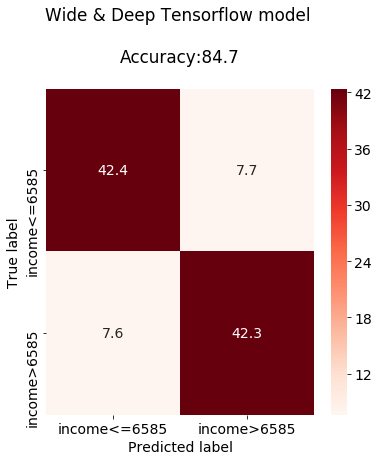

In [108]:
plot_confusion_matrix(final_preds, y_validation)

# Test model

In [109]:
test_preds = prediction(X_test)


INFO:tensorflow:Restoring parameters from PNAD_1525188046/model.ckpt-60002


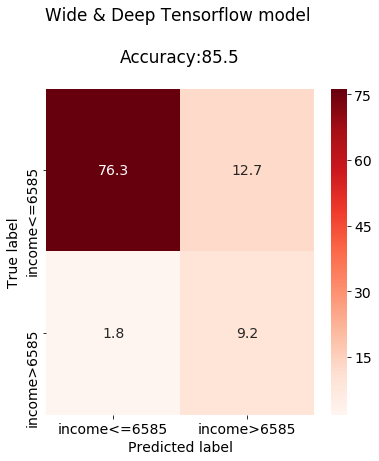

In [110]:
plot_confusion_matrix(test_preds, y_test)

## Tensorboard analysis

In [116]:
 #!tensorboard --logdir=<insert directory name>

# Check the 'not declared' income cases

In [111]:
df_preds = prediction(dataset_not_declared)

INFO:tensorflow:Restoring parameters from PNAD_1525188046/model.ckpt-60002


In [112]:
df_preds = pd.DataFrame(df_preds, columns=['Predictions'])

In [113]:
df_preds.shape

(5383, 1)

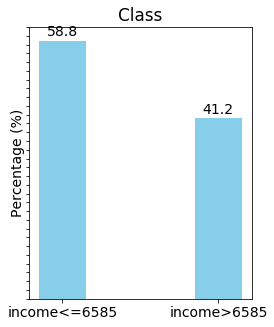

In [114]:
plot_bar_chart(df_preds['Predictions'],
               y_label='Percentage (%)',title='Class',color='SkyBlue',width = 0.30,x_axis_width=4)